<a href="https://colab.research.google.com/github/prateekbansal97/ChemicalDataScience/blob/main/notebooks/WS04_LMsForShakespeareAndProteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='#569098' size=20>Language Models for Shakespeare and Proteins</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

Tutorial adapted from Andrej Karpathy's [Video](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=1224s) and [Notebook](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing)

**OBJECTIVES: After completing this workshop, you will be able to:**

* <font color='#e59454'>Prepare and analyze a natural language dataset</font>
* <font color='#e59454'>Formulate the autoregressive training scheme in the training loop</font>
* <font color='#e59454'>Define and instantiate language model and compare architecture to prominent language models</font>
* <font color='#e59454'>Train language model on English language, then protein 'language' (fasta file of amino acid sequences)</font>

**_To save your work, please save a copy of this notebook into your  personal google drive._**

**<font color='#569098' size = 5> Table of Contents </font>**

**[Section 1: Introduction -- A bit of history](https://colab.research.google.com/drive/1zAvi6N8k5h5CQsTT4OYZjT1ng-ZzjXvW#scrollTo=BF4MA2fZAn9U&line=1&uniqifier=1)**

**[Section 2: Prepare dataset](https://colab.research.google.com/drive/1zAvi6N8k5h5CQsTT4OYZjT1ng-ZzjXvW#scrollTo=wDc4eL1hX8mu)**

* Use tokenization to map letters to an integer representation
* Formatting data for next token prediction training scheme
* Split data into train and validation splits

**[Section 3: Model](https://colab.research.google.com/drive/1zAvi6N8k5h5CQsTT4OYZjT1ng-ZzjXvW#scrollTo=aQA4YFCiX-pb)**

* Configure neural network hyperparameters
* Define key components of transformer block (attention, linear layer, feedforward layer)

**[Section 4: Training](https://colab.research.google.com/drive/1zAvi6N8k5h5CQsTT4OYZjT1ng-ZzjXvW#scrollTo=bPPT-IExpFCg)**

* Define training loop
* Evaluate performance on both train and validation sets

### <b> <font color='#569098'> Import Libraries

In [13]:
# imports
import torch
import torch.nn as nn
from torch.nn import functional as F

!wget --no-check-certificate 'https://drive.google.com/uc?id=1HuiOrdFmgggUDgOGOXcsV8eHvN56jweh' -O proteinPoem.gif



--2025-04-22 16:24:03--  https://drive.google.com/uc?id=1HuiOrdFmgggUDgOGOXcsV8eHvN56jweh
Resolving drive.google.com (drive.google.com)... 74.125.26.138, 74.125.26.113, 74.125.26.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1HuiOrdFmgggUDgOGOXcsV8eHvN56jweh [following]
--2025-04-22 16:24:04--  https://drive.usercontent.google.com/download?id=1HuiOrdFmgggUDgOGOXcsV8eHvN56jweh
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.12.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163525 (160K) [image/gif]
Saving to: ‘proteinPoem.gif’

proteinPoem.gif     100%[===================>] 159.69K  --.-KB/s    in 0.001s  

2025-04-22 16:24:06 (110 MB/s) - ‘proteinPoem.gif’

# <b> <font color='#569098'> Section 1: Introduction -- A bit of history</font>

ChatGPT has taken the world by storm! It is a system that allows you to interact with an AI that generates a text response from a text query. When you use ChatGPT, you will see that text is produced sequentially from left to right.

<center>
    <img src="https://jalammar.github.io/images/gpt3/04-gpt3-generate-tokens-output.gif" alt="Image" style="max-width: 100%;">
</center>

And if you ask the same question twice, you'll see a slightly different response. This is because ChatGPT is a *probabilistic system*, and for any one prompt it can give more than one response.

ChatGPT is what we call a *language model*, because it models a sequence of words/characters/tokens, and learns how certain words follow each other in natural language. The neural network under the hood of ChatGPT is the *transformer*. More specifically, the transformer decoder, known as the Generatively Pretrained Transformer (GPT). The original paper to propose this architecture is ["Attention is All You Need"](https://arxiv.org/abs/1706.03762), and within five years of its publication took over nearly all branches of AI applications.

Although building ChatGPT from scratch in a singular colab notebook would be unfeasible, we can still build and train a tiny transformer-based language model to learn some of the core concepts.

# <b> <font color='#569098'> Section 2: Preparing our Dataset

For this workshop we'll use the *tiny shakespeare* dataset, which is a concatenation of all of the works of Shakespeare in a single file (roughly 1 MB). We're going to model how these characters follow each other, to hopefully produce text that looks similar to the text it has been trained on.

Note: I suggest first completing this notebook with the Shakespeare dataset. However, the method for *tokenization* (explained below) is generalizable to most types of language in a txt file (i.e English, Spanish, Chinese, protein sequences, etc). The second time through this notebook, feel free to use any txt file of your choice.

If you would like to train your model to generate protein sequences, uncomment the second `wget` command below. This will download a file containing sequences in FASTA format for all entries in the PDB archive.

In [25]:
torch.manual_seed(1337)

# shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# protein dataset. I suggest first running model with shakespeare dataset
!wget https://files.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt


--2025-04-22 16:20:08--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2025-04-22 16:20:08 (17.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]

--2025-04-22 16:20:08--  https://files.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt
Resolving files.wwpdb.org (files.wwpdb.org)... 13.249.98.4, 13.249.98.124, 13.249.98.48, ...
Connecting to files.wwpdb.org (files.wwpdb.org)|13.249.98.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342682231 (327M) [text/plain]
Saving to: ‘pdb_seqres.txt’

pdb_seqres.txt      100%[=

In [7]:
# lets inspect our dataset
# if training on protein sequences... replace `input.txt` with `pdb_seqres.txt`
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()
# text = [j for j in text if not j.startswith('>')]

In [8]:
# roughly 1M characters
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [9]:
# first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



How many unique characters are there in the text?

In [10]:
# here are all the unique characters that occur in text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print('unique characters:')
print(''.join(chars))
print()
print('Vocab size:', vocab_size)

unique characters:

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Vocab size: 65


## **<font color='#569098'>Tokenizing our dataset**

Now we will *tokenize* the entire training set of Shakespeare. A tokenizer converts raw text data into smaller units called tokens. It processes the text by breaking it down into individual tokens, which can represent words, subwords, or characters, depending on the tokenizer's configuration. The tokenizer builds a vocabulary mapping tokens to numeric indices, facilitating the conversion of text data into numerical representations for the model.


<center>
    <img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F8d5e749c-b0bd-4496-85a1-9b4397ad935f_1400x787.jpeg" alt="Image" style="max-width: 100%;">
</center>

Tokenizers handle tasks like handling out-of-vocabulary words, incorporating special tokens for sequence boundaries, and may utilize subword tokenization techniques for morphologically rich languages or rare words. Ultimately, it prepares text data for language model training by transforming it into a format suitable for learning and processing by the model. Here we will use a pretty basic tokenizer which maps every unique/individual character to one integer.

In [11]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# sanity check that our decoder can properly decode our encoder
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Let's encode the entire text dataset and store it into a torch tensor. Now the entire dataset of text is stretched out as a single lone sequence of integers.

In [14]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will be provided to GPT in this format

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## **<font color='#569098'>Preparation for training**

Let's get ready to train! We're never going to feed the entire text all at once because it is too computationally expensive and can lead to relatively worse generalization. Instead, we only train with chunks of data at a time by sampling random chunks from the dataset. The max length of these chunks are called a `block size`, which is our first *hyperparameter* we will define.

In [15]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [16]:
block_size = 8
train_data[:block_size+1] # first 9 characters from training set

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

The language model is tasked with predicting the next token given a sequence of previous tokens. It segments the training data into input-output pairs, wher ethe input `x` consists of a sequence of tokens, and the output `y` represenst the token that immediately follows the text.

So, in the example above, the model is tasked with predicting the token `58` given the previous order of tokens `18, 47, 56, 57, 58,  1, 15, 47,`.

But instead of 1 prediction task, this can be augmented to 8 prediction tasks! With just this chunk the model can be trained to predict:
* Input `18` and output `47`
* Input `18, 47` and output `56`
* Input `18, 47, 56` and output `57`
* Etc...

By iterating over each position and forming context-target pairs, the model is trained to understand the sequential nature of the text data and make predictions accordingly, facilitating the learning of language patterns and generating coherent text sequences. This approach not only enhances training efficiency by increasing the amount of training data but also exposes the model to a variety of context lengths, allowing it to learn from short to longer sequences. During inference or generation, the model can be provided with as little as 1 character of context and predict up to the block size. However, if the context exceeds the block size, which is the maximum length the model was trained on, truncation is necessary. Truncation ensures that the input sequence length does not exceed the model's capacity, maintaining consistency with the training process and enabling effective generation of predictions within the model's capabilities.

In [17]:
# training on each segment is actually training on multiple sets of characters
x = train_data[:block_size] # inputs to transformer
y = train_data[1:block_size+1] # next block size characters (offset by 1). The targets for each input
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


This sequential nature of the input text data is often referred to as the *time dimension* of the tensor of a tokenized dataset. The time dimension influences how the input text is processed by the language model. During training, the model iterates over tokens along the "time" dimension, considering each token's context within the sequence. Likewise, during inference or prediction, the model generates output tokens sequentially, one token at a time, based on the preceding tokens in the sequence.

We've looked at the time dimension of the tensors, and now we will look at the *batch dimension*. In reality we will actually be feeding batches of text at a time to the transformers. This will allow us to take full advantage of the GPU, which allows us to process multiple chunks of data in parallel. BTW there's no "communication" between chunks of data processed in parallel. Each are done independently.

In [20]:
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch('train')
print('input intro transformer:')
print(xb.shape)
# print(xb)
print('targets:')
print(yb.shape)
# print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1] #Context, Target = C, T
        target = yb[b,t]
        # print(f"when input is {context.tolist()} the target: {target}")

input intro transformer:
torch.Size([16, 32])
targets:
torch.Size([16, 32])
----


In summary, the 16x8 input array above contains a total of 128 examples and they are completely independent

# <b > <font color='#569098'> Section 3: Model

Now that we have our data ready, let's start feeding this into neural networks!

This model is a Bigram Language Model implemented using a Transformer architecture. It generates text character by character based on a given input sequence. The model consists of 4 transformer blocks, each containing a multi-head self-attention mechanism and a feedforward neural network, followed by layer normalization. The model's output is then projected to predict the next character in the sequence. During training, it minimizes the cross-entropy loss between predicted and actual characters. Finally, the trained model is used to generate new text by sampling characters based on the predicted probability distribution.

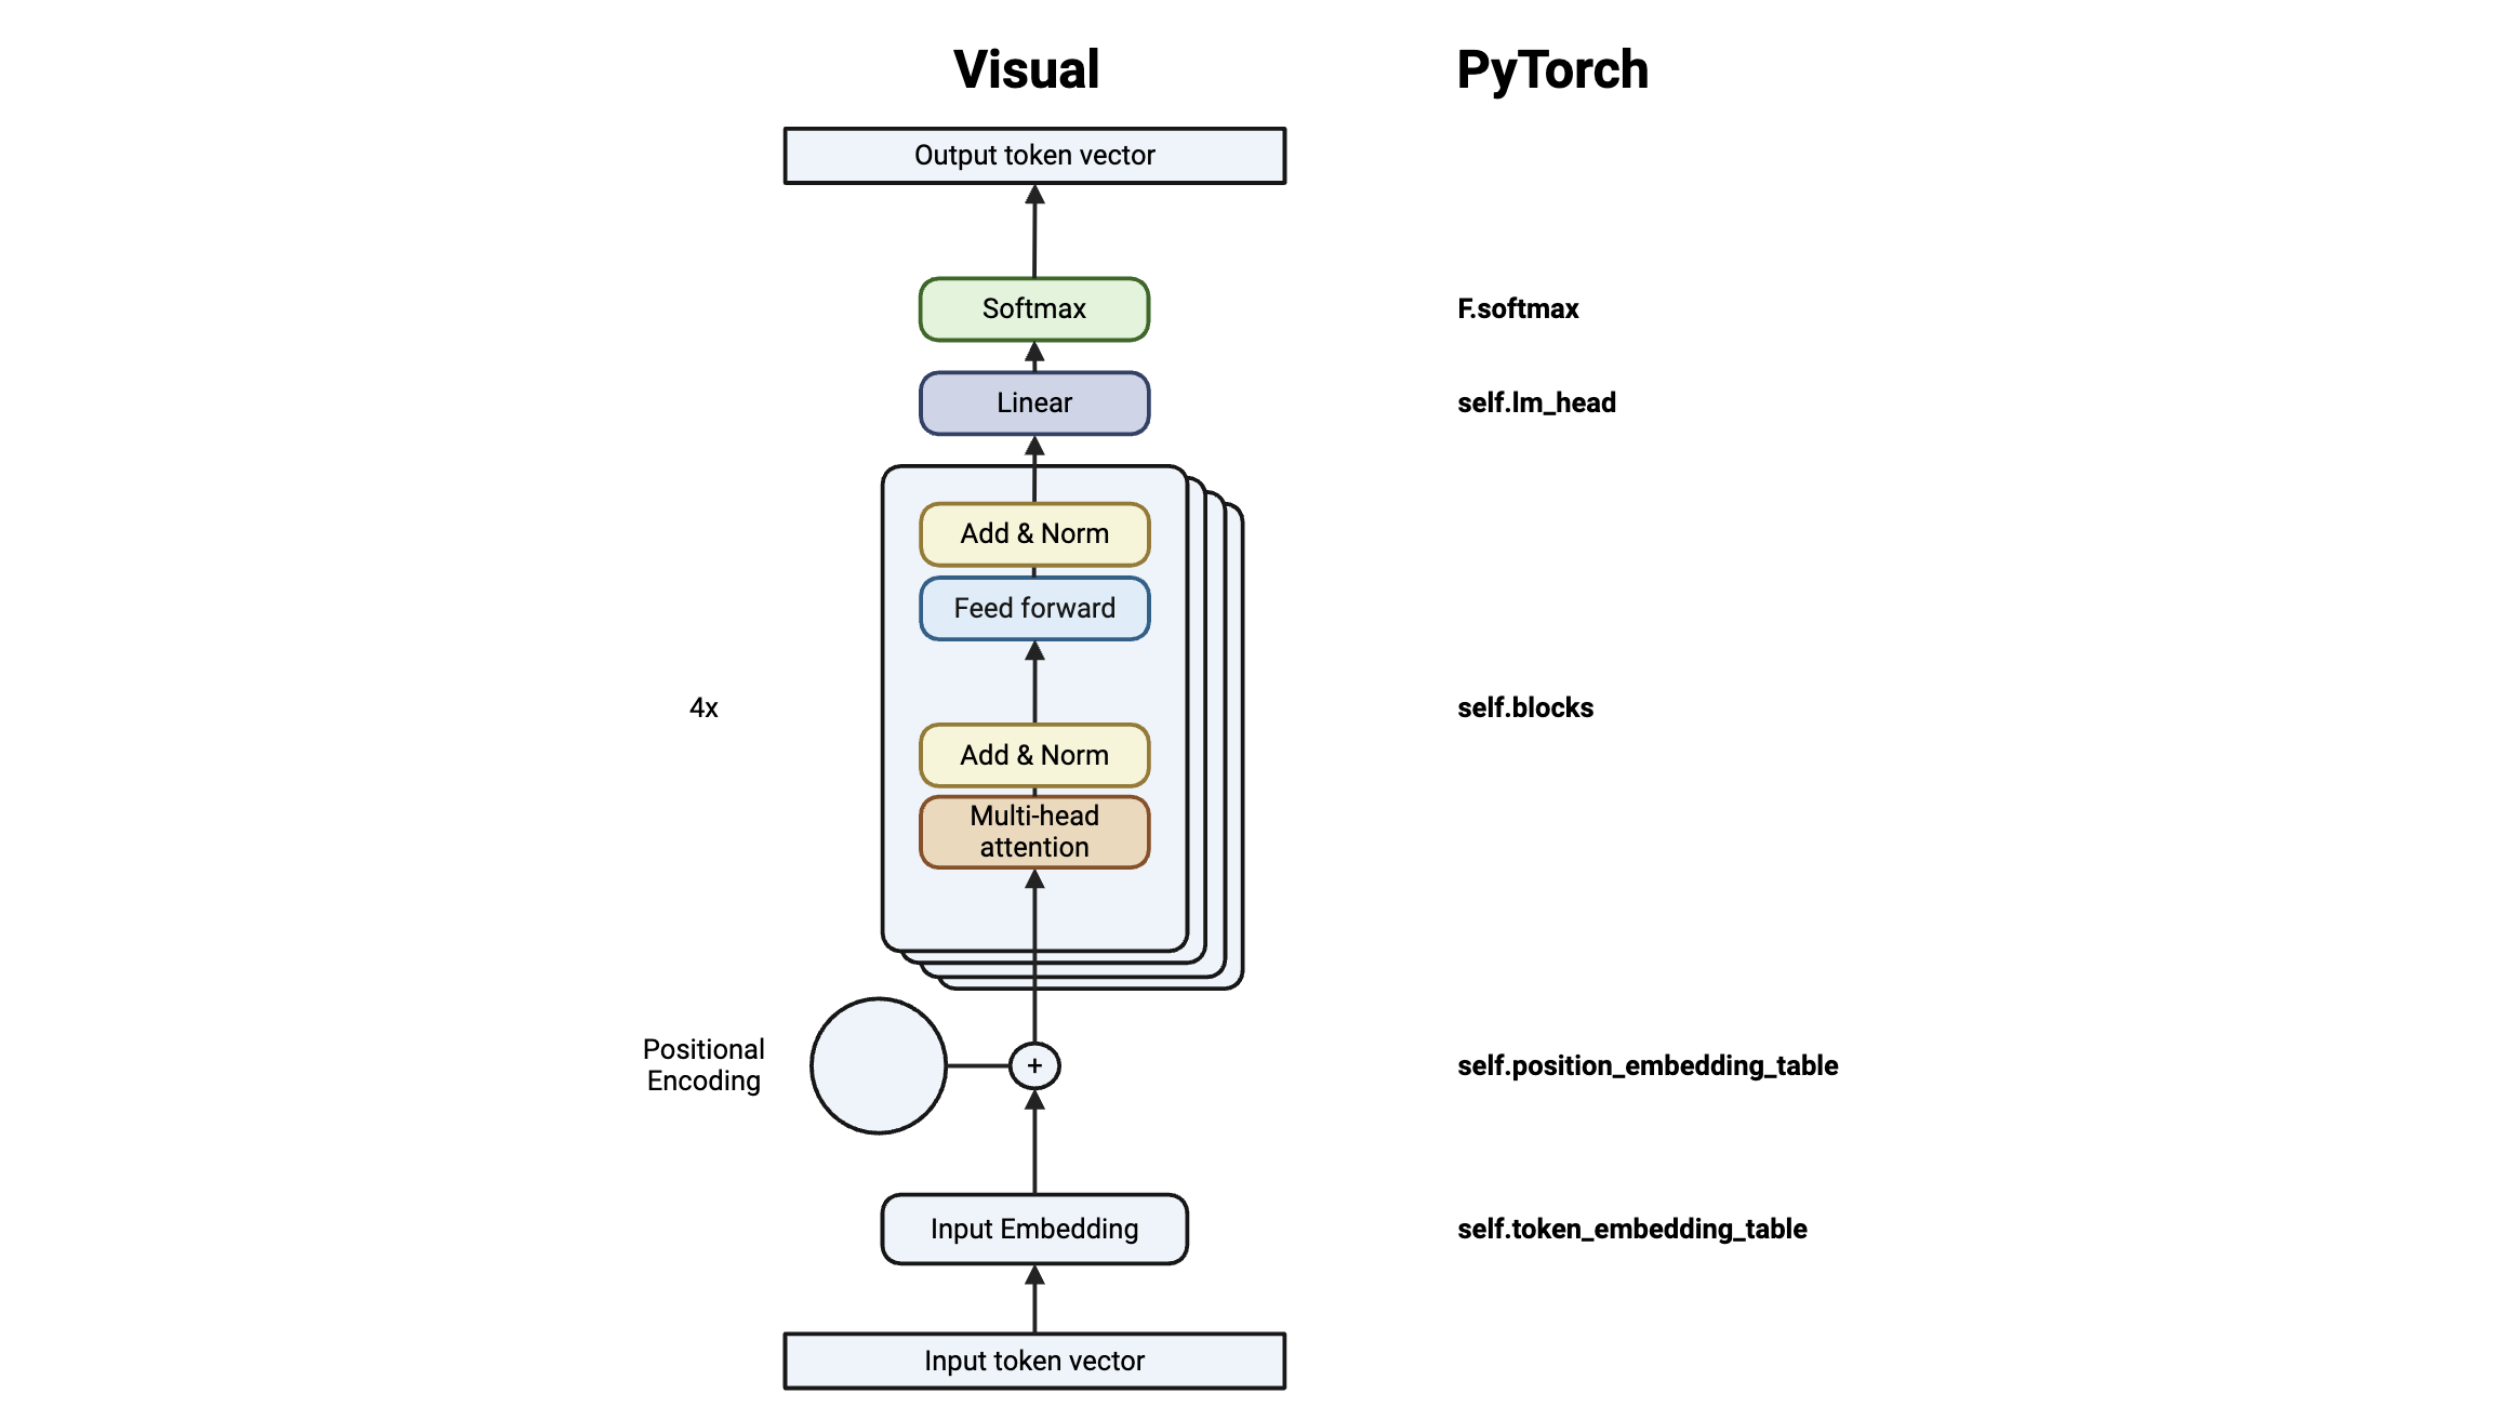



Both the model below and GPT are based on the transformer architecture. I outline some similaties and differences below:
* Number of layers: GPT models typically consist of a large number of transformer blocks (GPT1 has 12 blocks, GPT2-L has 48, GPT3-L has 384). Ours has 4 blocks
* GPT generates text token by token (where tokens are normally word fragments).Our model generates text character by character
* GPT processes variable length context sequences. Our model takes a fixed size context window (block size) and generates the next token based on this context

In [39]:
# hyperparameters
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

We define a function `estimate_loss()` which evaluates the loss of our NN on both training and validation data.The model is temporarily switched to evaluation mode to disable gradient calculation, enhancing computational efficiency. It iterates over training and validation splits, retrieving batches of data and computing losses. After computing the mean loss for each split, the model is reverted to training mode. Finally, the function returns a dictionary containing the mean losses for both splits. This aids in assessing the model's performance without updating its parameters, crucial for evaluation in machine learning tasks.

In [40]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

The major success of the transformer is *attention*, which we define in `Head` and `MultiHeadAttention`. The Head class represents a single head of self-attention, which is a fundamental component of transformer architectures. It initializes linear layers (self.key, self.query, and self.value) for computing key, query, and value representations, respectively, along with a triangular buffer for masking. In the forward method, it calculates attention scores, applies masking, computes attention weights, and aggregates values based on these weights.

The MultiHeadAttention class represents multiple heads of self-attention operating in parallel. It creates a list of Head instances (self.heads) to perform multi-headed attention. In the forward method, it applies each head individually to the input tensor x, concatenates the results, projects the concatenated output, and applies dropout for regularization. This class enables the model to capture different aspects of the input data simultaneously through multiple attention mechanisms, enhancing its representational capacity and performance.

In [46]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T). #For masking the future to prevent dataleakage
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        # print(B,T,C, k.shape, q.shape, v.shape, out.shape)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

The `FeedForward` class represents a simple feedforward neural network layer commonly found in transformer architectures. It contains two linear layers followed by ReLU activation and dropout for regularization. In the forward method, it applies these operations sequentially to the input tensor x, transforming it into a higher-dimensional space and introducing non-linearity.

The `Block` class represents a single transformer block, consisting of a multi-headed self-attention layer (self.sa) followed by a feedforward layer (self.ffwd). It also incorporates layer normalization (self.ln1 and self.ln2) after each sub-layer. In the forward method, it passes the input tensor x through the self-attention layer and feedforward layer sequentially, adds the original input to the output of each layer (residual connection), and normalizes the result using layer normalization. This block encapsulates the key components of transformer models, facilitating both information exchange between tokens via attention and non-linear transformations through feedforward layers.

In [47]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

The `BigramLanguageModel` class consists of an embedding layer for token representation, a positional embedding layer to capture token positions within the sequence, a stack of transformer blocks for processing the input, layer normalization for stabilizing training, and a linear layer for predicting the next token. During the forward pass, the model takes input indices representing tokens, applies embeddings and positional encodings, processes them through transformer blocks, and predicts the next token's logits. It then computes the loss. For generation, the model samples from the predicted distribution iteratively, selecting the next token based on the previous context and probabilities generated by the model. This approach allows the model to generate sequences of tokens autonomously.

In [48]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


Instantiating model

In [49]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.209729 M parameters


# <b> <font color='#569098'>Section 4: Training

The code runs a loop for max_iters iterations. Every eval_interval iterations (or in the last iteration), it evaluates the loss on both the training and validation sets using the estimate_loss() function and prints the results.
It then samples a batch of data (xb, yb) from the training set using the get_batch() function. The model is called with the input (xb) and target (yb) tensors to compute the logits and loss. The optimizer's gradient is zeroed (optimizer.zero_grad()) with set_to_none=True, which allows more efficient memory usage. Backpropagation is performed (loss.backward()) to compute gradients. Finally, the optimizer takes a step (optimizer.step()) to update the model parameters based on the computed gradients.

In [50]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16])
256 32 64 torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) torch.Size([256, 32, 16]) 

KeyboardInterrupt: 

After training, text generation is demonstrated by providing an initial context (context) as a tensor of zeros. Since the context tensor is initialized with zeros, it essentially represents an empty starting point for text generation. The language model will use this empty context as the beginning of the generated sequence and progressively generate tokens based on its learned patterns and the provided context. As tokens are generated, they will be appended to the context tensor, allowing the model to continue generating text based on the evolving sequence.


The model's generate method is called to generate a sequence of tokens (max_new_tokens=2000) based on the given context. The generated sequence is decoded into text format and printed. As you can see the generated text isnt fully legible, but the model has done a decent job at capturing the general structure of the training data.

In [ ]:
# generate from the model
# if generating proteins... if you want to see how 'protein-like' the sequences are, feed them into AlphaFold2 and see if the sequence folds!!
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))


Why not call, Clifffay, all there me fear the labluntch but your Cappence agmand to
Too.

MONSARY:
Good
Where these bappedied Droum, to
I will depi'gr not love fellow the my breath,
Than furthon that My love tambled thy followns and the like daming this di;
And and he but thever is very may moung twict the Levings. Consticly
Me brothers gate?
Not, now you some, what that my frece fullw'd thou brother,
As my live, ashow thyself den; and is thurncts'd wher here's up?
I would loves minow. Pomfort life, shom Conty-driack: sol, and,
And,--like as may that Kingly testens can xpurthymen, shall where like
Thel, I haffit, thy not loves!
And consent the brody with in in but the carrition.
Camb'd, take His this you
ruther thine why, I'll mansce's have with a what fell wailt afwifed
God stild thou lost; as now, I have this rypengt.

LANTA:
He is not Plow; deyelf, good whither
Forth: you, would it: and thus for not
And sabetruess this let old this
As kneep ausis, trulow.--greaden of them heavy:
Wh

Let's also generate text from a more specific context

In [ ]:
# input context. Change this to whatever you want!
# if you are generating protein sequences... try inserting the first feww residues of a protein chain!
input_context = "In the house of"

# encode input
encoded_context = encode(input_context)

# input into tensor
context = torch.tensor([encoded_context], dtype=torch.long, device=device)

# generate text using context
generated_text = m.generate(context, max_new_tokens=100)[0].tolist()

# decode and print text
print(decode(generated_text))

In the house of the brow you not.

DUCHSHOMAND:
Go denemings given they Comentence,
Sincoud ir, I am your her
Water


## **<font color='#569098'>Questions**

Lets modify our model's hyperparameters and see how each affects the model's performance!

**Question**: Increase `n_embd` (embedding size) from 64 to a higher value (such as 128 or 256). How does this affect performance compared to the original model?

In [ ]:
#@markdown <font color='#e59454'>Run to See Answer!</font>

print("\n Increasing the embedding size allows the model to capture more nuanced patterns in the data. \n A larger embedding dimension generally improves the model's capacity to understand and generate more complex language features. \n Final loss should decrease.")


**Question**: Increase `n_layer` (number of transformer layers) from 4 to a higher value (such as 6 or 8). How does this affect the model's performance?

In [ ]:
#@markdown <font color='#e59454'>Run to See Answer!</font>

print("\n More layers allow the model to learn deeper hierarchical patterns, which is important for capturing long-range dependencies in text. \n The final loss should decrease due to better capacity to model long-range dependencies.")


**Question**: Increase `n_head` (the number of attention heads) from 4 to a higher value (such as 8 or 16). How does this affect model performance?

In [ ]:
#@markdown <font color='#e59454'>Run to See Answer!</font>

print("\n More attention heads allow the model to capture multiple aspects of relationships between tokens in parallel. \n Increasing the number of attention heads can improve the model’s ability to focus on different parts of the input simultaneously. \n The final loss should decrease.")


In general, scaling up transformer models by increasing the embedding size, number of layers, or number of attention heads tends to improve performance across many natural language processing tasks. This trend arises because larger models have greater capacity to capture more complex patterns, relationships, and dependencies in the data. With more parameters, the model can better generalize from training data and generate more accurate, coherent, and contextually rich outputs. However, the gains from scaling diminish at a certain point, and careful tuning of hyperparameters is necessary to avoid overfitting or inefficiencies, especially with limited data or computational resources.

**Relevant papers**
* Simulating 500 million years of evolution with a language model, Hayes et al, 2024
* ESM Cambrian: Revealing the mysteries of proteins with unsupervised learning, 2024
* Addressing the antibody germline bias and its effect on language models for improved antibody design, 2024
* The Protein Language Visualizer: Sequence Similarity Networks for the Era of Language Models, 2024
* Fine-tuning protein language models boosts predictions across diverse tasks, 2024
* Long-context Protein Language Model, 2024
* Training Compute-Optimal Protein Language Models, 2024
* Multi-purpose controllable protein generation via prompted language models, 2024
* Designing proteins with language models, 2024
* Protein language models learn evolutionary statistics of interacting sequence motifs, 2024
* p-IgGen: A Paired Antibody Generative Language Model, 2024
* Are Protein Language Models Compute Optimal?, 2024
* Feature Reuse and Scaling: Understanding Transfer Learning with Protein Language Models, 2024
* Adapting protein language models for structure-conditioned design, 2024
* On Recovering Higher-order Interactions from Protein Language Models, 2024
* Protein language models are biased by unequal sequence sampling across the tree of life, 2024
* ESM All-Atom: Multi-Scale Protein Language Model for Unified Molecular Modeling, 2024
* Knowledge-aware Reinforced Language Models for Protein Directed Evolution, 2024
* Multi-Modal Large Language Model Enables Protein Function Prediction, 2024
* Benchmarking text-integrated protein language model embeddings and embedding fusion on diverse downstream tasks, 2024
* Large scale paired antibody language models, 2024
* Unsupervised evolution of protein and antibody complexes with a structure-informed language model, 2024
* Improving antibody language models with native pairing, 2023
* Large language models generate functional protein sequences across diverse families, 2023
* ProGen2: Exploring the Boundaries of Protein Language Models, 2022
* Generative Language Modeling for Antibody Design, 2023
* Language models of protein sequences at the scale of evolution enable accurate structure prediction, 2023